In [1]:
import pandas as pd
import scanpy as sc
import scirpy as ir

In [2]:
import sys
sys.path.append('../..')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

In [3]:
def load_model(adata, split, model):
    path_model = f'saved_models/journal/Bcells_covid_spec_noPoly/{model}/bcells_{model}_{split}.pt'
    model = utils.load_model(adata, path_model)
    return model

In [4]:
def load_data(split):
    adata = utils.load_data('Bcells_covid')
    adata = adata[adata.obs['Specificity'] != 'Probe_Negative']
    adata = adata[adata.obs['Specificity'] != 'Probe_Poly']
    
    random_seed = split
    train_val, test = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=random_seed)
    train, val = group_shuffle_split(train_val, group_col='clonotype', val_split=0.25, random_seed=random_seed)

    adata.obs['set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata.obs.loc[test.obs.index, 'set'] = 'test'
    return adata


In [5]:
metadata = ['Specificity', 'clonotype', 'sample']

model_names = []
splits = []
metrics = []
scores = []

for split in range(0, 5):
    data = load_data(split)
    for model_name in ['moe', 'rna']:
        print(f'split: {split},  model: {model_name}')
        model = load_model(data, split, model_name)
        test_embedding_func = get_model_prediction_function(model)
        for source in ['test']:#, 'val']:
            summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                        label_pred='Specificity')
            result = summary['knn']['weighted avg']['f1-score']
            
            model_names.append(model_name)
            splits.append(split)
            metrics.append(f'Prediction {source}')
            scores.append(result)
            for spec in ['Probe_ORF8', 'Probe_Spike', 'Probe_NP', 'Probe_Cocktail']:
                result = summary['knn'][spec]['f1-score']

                model_names.append(model_name)
                splits.append(split)
                metrics.append(f'Prediction {spec}')
                scores.append(result)
        
        best_nmi = -99
        for resolution in [0.01, 0.1, 1.0]:
            cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='Specificity', 
                                               cluster_params={'resolution': resolution, 'num_neighbors': 5})
            best_nmi = max(cluster_result['NMI'], best_nmi)
        model_names.append(model_name)
        splits.append(split)
        metrics.append('NMI')
        scores.append(best_nmi)
        

results = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results = pd.DataFrame(results)
results.to_csv('results/performance_bcells.csv')
results

Trying to set attribute `.obs` of view, copying.


split: 0,  model: moe
split: 0,  model: rna


Trying to set attribute `.obs` of view, copying.


split: 1,  model: moe
split: 1,  model: rna


Trying to set attribute `.obs` of view, copying.


split: 2,  model: moe
split: 2,  model: rna


Trying to set attribute `.obs` of view, copying.


split: 3,  model: moe
split: 3,  model: rna


Trying to set attribute `.obs` of view, copying.


split: 4,  model: moe
split: 4,  model: rna


,model,split,metrics,scores
0,moe,0,Prediction test,0.528321
1,moe,0,Prediction Probe_ORF8,0.574154
2,moe,0,Prediction Probe_Spike,0.576058
3,moe,0,Prediction Probe_NP,0.380952
4,moe,0,Prediction Probe_Cocktail,0.549020
5,moe,0,NMI,0.125786
6,rna,0,Prediction test,0.533344
7,rna,0,Prediction Probe_ORF8,0.575229
8,rna,0,Prediction Probe_Spike,0.594697
9,rna,0,Prediction Probe_NP,0.407465


In [6]:
results.groupby(['model', 'metrics'])['scores'].mean()

model  metrics                  
moe    NMI                          0.124575
       Prediction Probe_Cocktail    0.557054
       Prediction Probe_NP          0.385620
       Prediction Probe_ORF8        0.550624
       Prediction Probe_Spike       0.599976
       Prediction test              0.531577
rna    NMI                          0.156127
       Prediction Probe_Cocktail    0.523828
       Prediction Probe_NP          0.395225
       Prediction Probe_ORF8        0.564082
       Prediction Probe_Spike       0.604106
       Prediction test              0.537628
Name: scores, dtype: float64

In [7]:
results[results['metrics']=='Prediction test']

,model,split,metrics,scores
0,moe,0,Prediction test,0.528321
6,rna,0,Prediction test,0.533344
12,moe,1,Prediction test,0.551472
18,rna,1,Prediction test,0.570492
24,moe,2,Prediction test,0.526611
30,rna,2,Prediction test,0.526682
36,moe,3,Prediction test,0.515704
42,rna,3,Prediction test,0.512767
48,moe,4,Prediction test,0.535779
54,rna,4,Prediction test,0.544857


In [8]:
import seaborn as sb

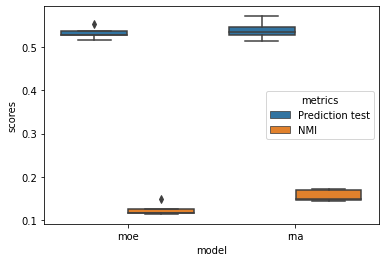

In [9]:
plot = sb.boxplot(data=results[results['metrics'].isin(['Prediction test', 'NMI'])],
                               x='model', y='scores', hue='metrics')

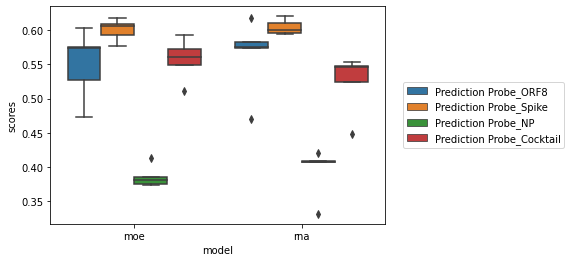

In [10]:
import matplotlib.pyplot as plt
plot = sb.boxplot(data=results[~results['metrics'].isin(['Prediction test', 'NMI'])],
                               x='model', y='scores', hue='metrics')
plt.legend(loc='right', bbox_to_anchor=(1.55, 0.5))

Trying to set attribute `.obs` of view, copying.
... storing 'set' as categorical


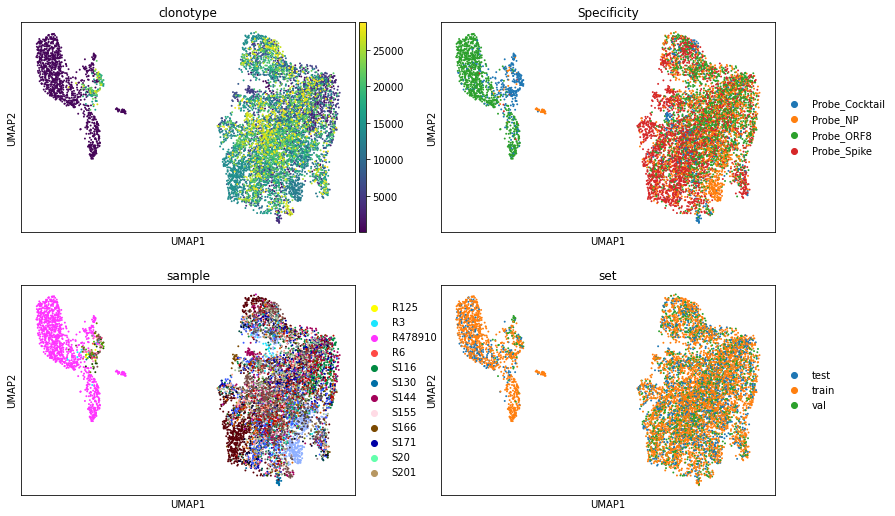

... storing 'set' as categorical


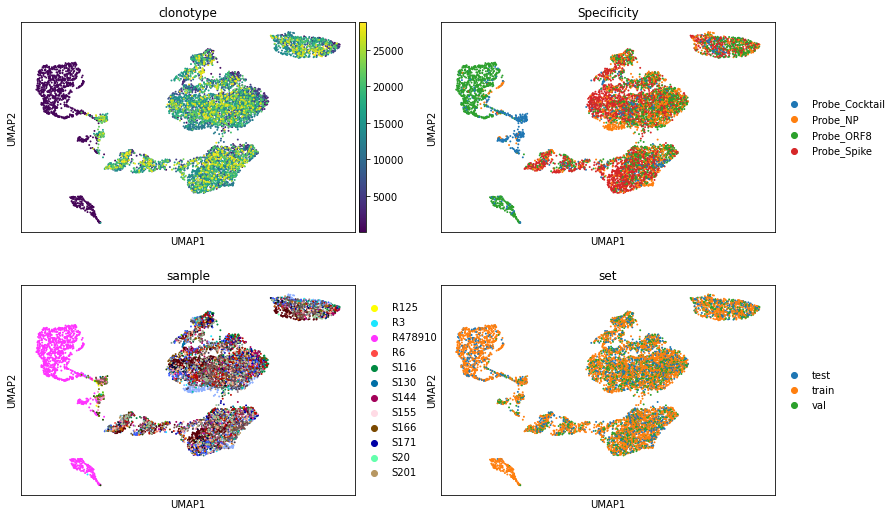

In [11]:
metadata = ['clonotype', 'Specificity', 'sample', 'set']
data = load_data(0)
data_tmp = data[data.obs['Specificity']!='Probe_Negative']
data_tmp = data_tmp[data_tmp.obs['Specificity']!='Probe_Poly']

for model in ['rna', 'moe']:
    model = load_model(data_tmp, 3, model)
    latent = model.get_latent(data_tmp, metadata=metadata)
    sc.pp.neighbors(latent)
    sc.tl.umap(latent)
    sc.pl.umap(latent, color=metadata, ncols=2)

... storing 'set' as categorical


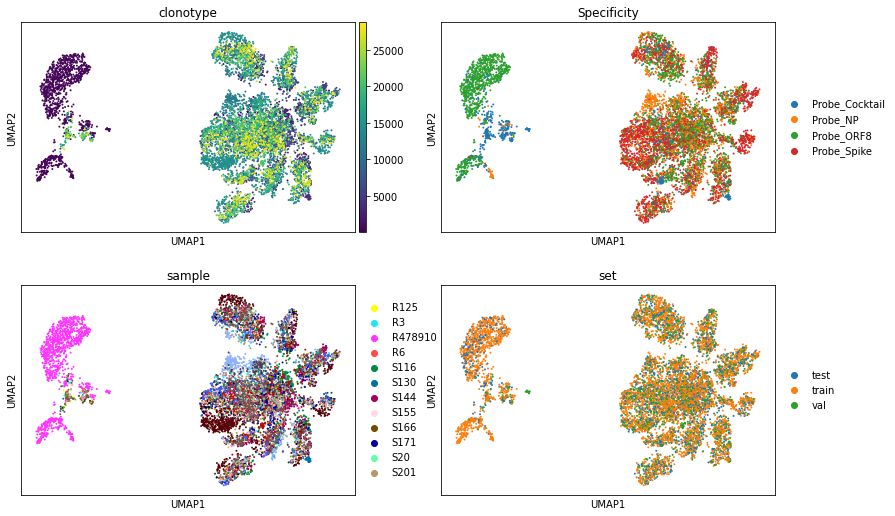

In [12]:
data_tmp = data[data.obs['Specificity']!='Probe_Negative']
data_tmp = data_tmp[data_tmp.obs['Specificity']!='Probe_Poly']
sc.pp.neighbors(data_tmp)
sc.tl.umap(data_tmp)
sc.pl.umap(data_tmp, color=metadata, ncols=2)

In [13]:
data.obs['Specificity'].value_counts()

Probe_ORF8        2949
Probe_Spike       2636
Probe_NP          1708
Probe_Cocktail     637
Name: Specificity, dtype: int64

In [14]:
data.obs.groupby('Specificity')['sample'].value_counts()

Specificity     sample 
Probe_Cocktail  R478910    158
                S65        132
                S272        56
                S130        54
                R3          36
                          ... 
Probe_Spike     S281         4
                S20          3
                S586         3
                R6           1
                S155         1
Name: sample, Length: 121, dtype: int64

In [15]:
ir.pl.group_abundance(data, groupby='sample', target_col='Specificity', fig_kws={"figsize": (15, 3)})
ir.pl.group_abundance(data, groupby='sample', target_col='Specificity', fig_kws={"figsize": (15, 3)}, normalize=True)
ir.pl.group_abundance(data, groupby='Specificity', target_col='sample', fig_kws={"figsize": (15, 3)})
ir.pl.group_abundance(data, groupby='Specificity', target_col='sample', fig_kws={"figsize": (15, 3)}, normalize=True)

ValueError: Scirpy has updated the the format of `adata.obs` in v0.7. Please run `ir.io.upgrade_schema(adata)` to update your AnnData object to the latest version. 
If you are sure your schema is up-to-date, you can override this message by setting `adata.uns['scirpy_version'] = '0.7'`

In [ ]:
data_tmp = data[data.obs['Specificity']!='Probe_Negative']

ir.pl.group_abundance(data_tmp, groupby='sample', target_col='Specificity', fig_kws={"figsize": (15, 3)})
ir.pl.group_abundance(data_tmp, groupby='sample', target_col='Specificity', fig_kws={"figsize": (15, 3)}, normalize=True)
ir.pl.group_abundance(data_tmp, groupby='Specificity', target_col='sample', fig_kws={"figsize": (15, 3)})
ir.pl.group_abundance(data_tmp, groupby='Specificity', target_col='sample', fig_kws={"figsize": (15, 3)}, normalize=True)

In [1]:
trials_moe = {
    1: 33,
    2: 79,
    3: 94,
#    4: 159 
}

trials_rna = {
    1: 92,
    2: 43,
    3: 59,
#    4: 429
}


In [2]:
def scp_command(m, s, t):
    cmd = 'scp felix.drost@sepp:'
    cmd += f'/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_{m}_split_{s}/trial_{t}/'
    cmd += 'best_model_by_metric.pt'
    cmd += f' /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/{m}/bcells_reac_{m}_{s}.pt'
    return cmd

In [3]:
for s, t in trials_moe.items():
    print(scp_command('moe', s, t))
    print('3Lenovo95')
    print()

scp felix.drost@sepp:/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_moe_split_1/trial_33/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/moe/bcells_reac_moe_1.pt
3Lenovo95

scp felix.drost@sepp:/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_moe_split_2/trial_79/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/moe/bcells_reac_moe_2.pt
3Lenovo95

scp felix.drost@sepp:/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_moe_split_3/trial_94/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/moe/bcells_reac_moe_3.pt
3Lenovo95



In [4]:
for s, t in trials_rna.items():
    print(scp_command('rna', s, t))
    print('3Lenovo95')
    print()

scp felix.drost@sepp:/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_rna_split_1/trial_92/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/rna/bcells_reac_rna_1.pt
3Lenovo95

scp felix.drost@sepp:/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_rna_split_2/trial_43/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/rna/bcells_reac_rna_2.pt
3Lenovo95

scp felix.drost@sepp:/storage/groups/imm01/workspace/felix.drost/mvTCR/optuna/Bcells_covid_reac_wi_rna_split_3/trial_59/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/Bcells_covid_reac/rna/bcells_reac_rna_3.pt
3Lenovo95

